In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import sys
sys.path.append('../')

In [31]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

from src.load_data import load_oil_price_data

import warnings
warnings.filterwarnings('ignore')

## Data loading

In [6]:
start_date = "2022-09-26"
df = load_oil_price_data(start_date)

In [7]:
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2023-09-21 00:00:00-04:00,81.250000,81.510002,80.400002,80.410004,3095900,0.0,0.0,0.0
2023-09-22 00:00:00-04:00,81.550003,81.599998,79.989998,80.629997,2704300,0.0,0.0,0.0
2023-09-25 00:00:00-04:00,80.589996,80.650002,79.669998,80.389999,1918300,0.0,0.0,0.0
2023-09-26 00:00:00-04:00,79.970001,81.050003,79.889999,80.879997,2517200,0.0,0.0,0.0
2023-09-27 00:00:00-04:00,79.970001,82.250000,82.180000,82.220001,123688,0.0,0.0,0.0


<Axes: xlabel='Date'>

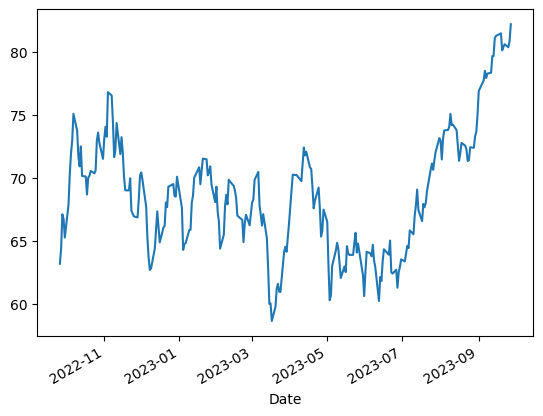

In [8]:
df.Close.plot()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2022-09-26 00:00:00-04:00 to 2023-09-27 00:00:00-04:00
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           253 non-null    float64
 1   High           253 non-null    float64
 2   Low            253 non-null    float64
 3   Close          253 non-null    float64
 4   Volume         253 non-null    int64  
 5   Dividends      253 non-null    float64
 6   Stock Splits   253 non-null    float64
 7   Capital Gains  253 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 17.8 KB


## Data Preprocessing

In [10]:
resample_frequency = 'D'
df_resampled = df.resample(resample_frequency).asfreq()
for column in df.columns:
    df_resampled[f'{column}'].interpolate(method='linear', inplace=True)

df_resampled['MissingData'] = df_resampled['Open'].isnull().astype(int)

In [11]:
df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 367 entries, 2022-09-26 00:00:00-04:00 to 2023-09-27 00:00:00-04:00
Freq: D
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           367 non-null    float64
 1   High           367 non-null    float64
 2   Low            367 non-null    float64
 3   Close          367 non-null    float64
 4   Volume         367 non-null    float64
 5   Dividends      367 non-null    float64
 6   Stock Splits   367 non-null    float64
 7   Capital Gains  367 non-null    float64
 8   MissingData    367 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 28.7 KB


<Axes: xlabel='Date'>

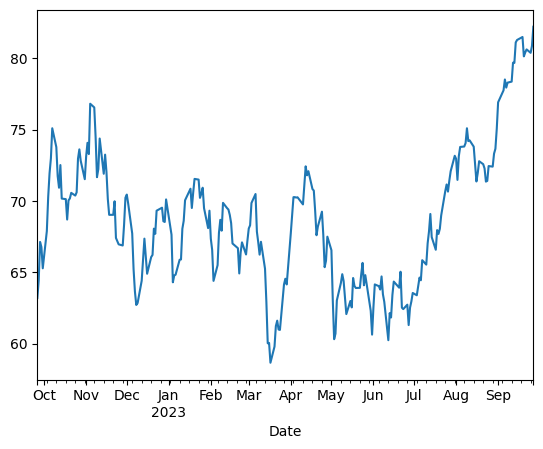

In [12]:
df_resampled.Close.plot()

## SARIMAX model

In [33]:
train_size = int(0.95 * len(df_resampled))
train_data = df_resampled.iloc[:train_size]
test_data = df_resampled.iloc[train_size:]

In [34]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

In [51]:
p, d, q, P, D, Q, S = (2, 1, 1, 2, 2, 2, 12)

In [52]:
mse = []

In [53]:
for train_index, test_index in tscv.split(train_data):
    train_fold = train_data.iloc[train_index]
    test_fold = train_data.iloc[test_index]

    sarima_model = sm.tsa.SARIMAX(train_fold['Close'], order=(p, d, q), seasonal_order=(P, D, Q, S))

    try:
        sarima_result = sarima_model.fit(disp=False)

        forecast = sarima_result.get_forecast(steps=len(test_fold))
        forecast_values = forecast.predicted_mean

        mse.append(mean_squared_error(test_fold['Close'], forecast_values))

    except Exception as e:
        continue

In [54]:
mse

[330.94345956358353, 185.83537850552372, 23.4755976869623, 3.792971126567519]

In [55]:
sarima_model = sm.tsa.SARIMAX(train_data['Close'], order=(p, d, q), seasonal_order=(P, D, Q, S))
sarima_result = sarima_model.fit(disp=False)

In [56]:
forecast = sarima_result.get_forecast(steps=len(test_data))
forecast_values = forecast.predicted_mean

In [57]:
mse = mean_squared_error(test_data['Close'], forecast_values)
mae = mean_absolute_error(test_data['Close'], forecast_values)

print(f"Среднеквадратическая ошибка (MSE): {mse}")
print(f"Средняя абсолютная ошибка (MAE): {mae}")


Среднеквадратическая ошибка (MSE): 5.516240701688606
Средняя абсолютная ошибка (MAE): 2.076057021167064


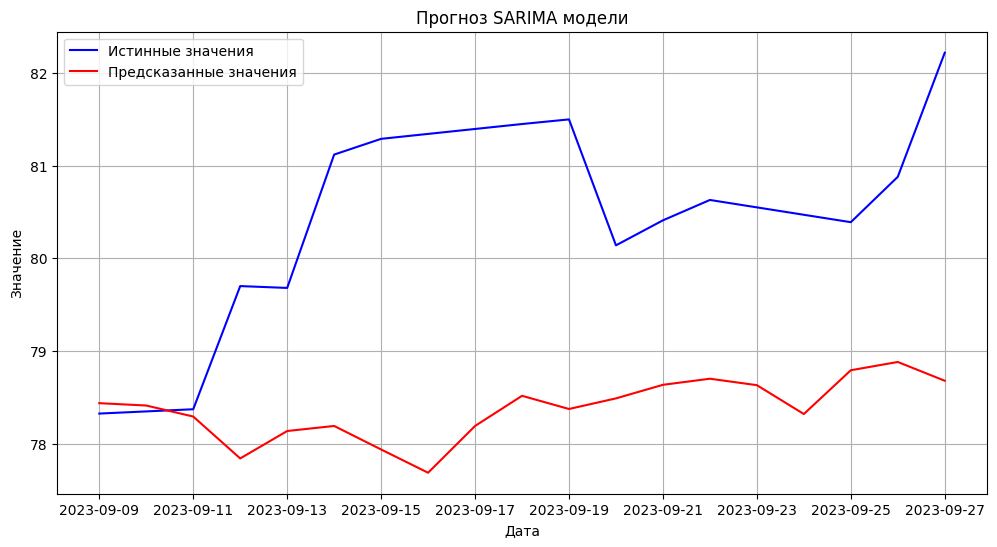

In [58]:
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['Close'], label='Истинные значения', color='blue')
plt.plot(test_data.index, forecast_values, label='Предсказанные значения', color='red')

plt.title('Прогноз SARIMA модели')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)

plt.show()
